# Basic characterizations of UA Q4
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 3 # for UA Q4
res_index = 3 # for UA Q4
flux_index = 3 # for UA Q4
TLS_index = 0 # for TLS of interest

2024-04-26 13:41:21,675 - qm - INFO     - Starting session: 22fb5e87-a70a-4f66-a729-f93b86bb9bec


In [2]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [53]:
# Set all DC bias to 0
for i in np.arange(7):
    val = machine.flux_lines[i].dc_voltage       
    machine.flux_lines[i].dc_voltage -= val
machine = Analysis.set_machine(machine)

In [3]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [55]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [56]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-04-26 13:32:05,653 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-26 13:32:05,659 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-04-26 13:32:13,934 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.936 GHz, -50.000 MHz)
2024-04-26 13:32:27,889 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Time of flight

DC offset to add to I: -0.000042 V
DC offset to add to Q: 0.000416 V
TOF to add: 12.0 ns


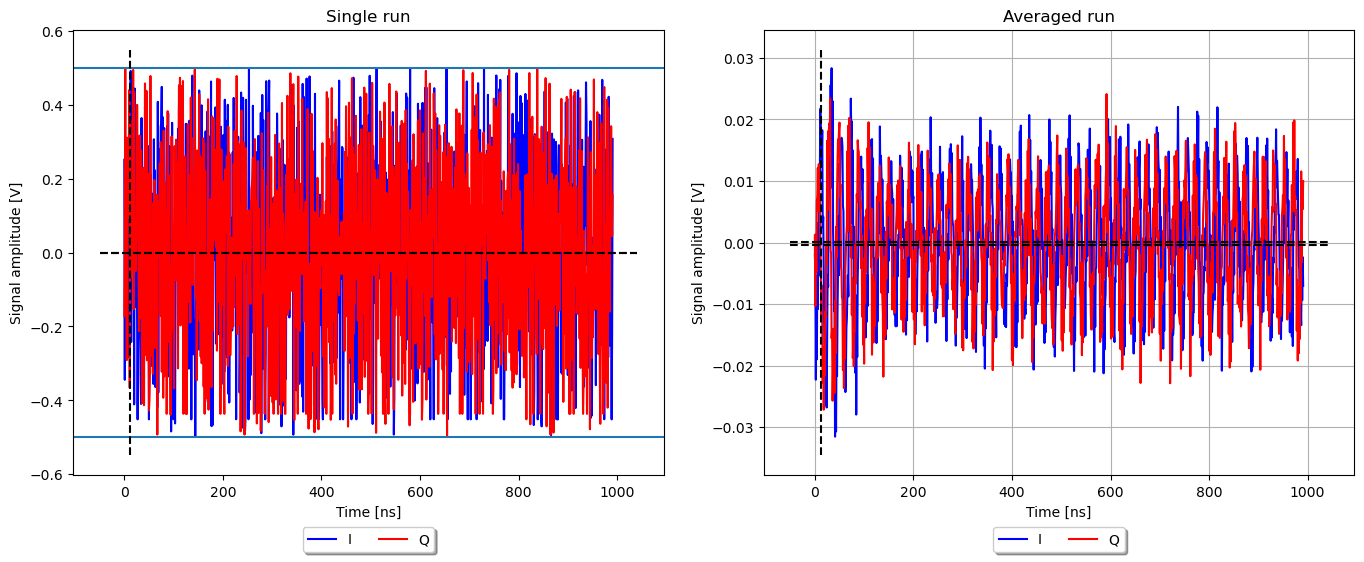

In [67]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 5E3, cd_time = 10E3, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [68]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += dc_offset_i.item()
machine.global_parameters.con1_downconversion_offset_Q += dc_offset_q.item()
# machine.resonators[res_index].readout_pulse_amp = 0.32
# machine.global_parameters.time_of_flight = 304
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.43s


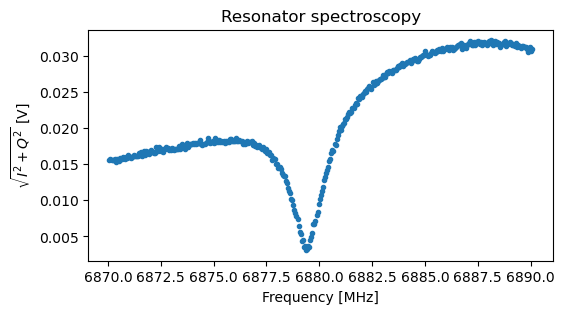

In [69]:
%matplotlib inline
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                           n_avg = 1E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)

resonator frequency: 6879.371 MHz


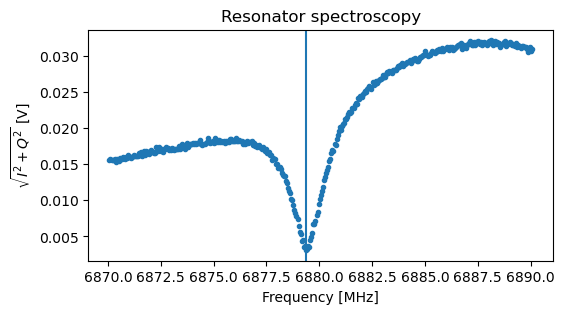

In [70]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine = Analysis.set_machine(machine)

## 2D RO resonator spectroscopy vs DC flux

In [71]:
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-6e6, 5e6, 0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, 
                                plot_flag = False, n_avg = 2E3, cd_time = 10E3)

Progress: [##################################################] 100.0% (n=37/37)


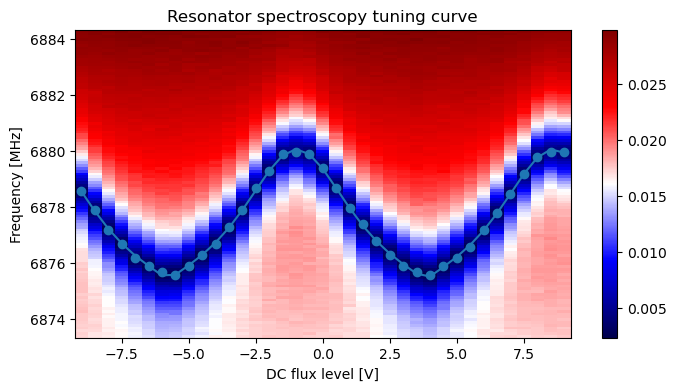

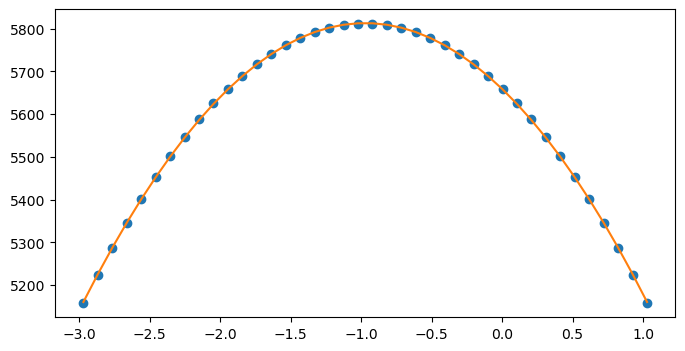

In [72]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [73]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [74]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].DC_tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [75]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 21.19s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 21.24s
resonator frequency: 6879.956 MHz


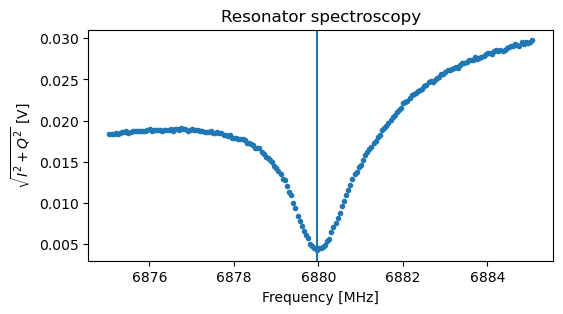

In [76]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 20E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [4]:
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag=True)

2024-04-26 13:41:33,745 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2024-04-26 13:41:33,749 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-26 13:41:33,769 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-04-26 13:41:42,080 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.936 GHz, -50.000 MHz)
2024-04-26 13:41:55,350 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [7]:
if True: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
    
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-250E6, 300E6 + 1, 5E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 0.04, ff_amp = 0.0, n_avg = 10E3, cd_time = 30E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 35.96s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 36.01s


resonant frequency: 5639.687 MHz


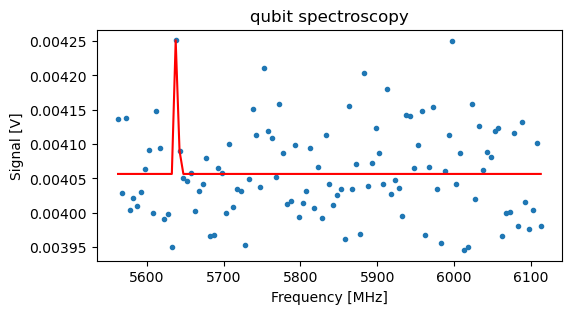

In [8]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
# qubit_freq = int(qubit_freq.tolist())
# machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
# machine.qubits[qubit_index].lo = qubit_freq + 50E6
# machine.qubits[qubit_index].f_tls[0] = qubit_freq + 0E6
# machine = Analysis.set_machine(machine)

In [275]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag = True)

2024-04-03 11:36:49,772 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-04-03 11:36:49,782 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-04-03 11:36:57,594 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.936 GHz, -50.000 MHz)
2024-04-03 11:37:11,020 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Rabi

### time rabi

In [284]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 1100 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 0.04, n_avg = 1E3, cd_time = 30E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 36.40s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 36.45s


rabi_pi_pulse: 2392.8 ns
half period: 4096.00 ns


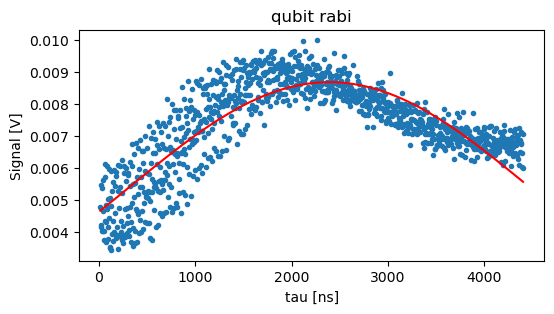

In [285]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [286]:
machine.qubits[qubit_index].pi_length[0] = 1000
machine = Analysis.set_machine(machine)

### power rabi

In [165]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.01, 1.5, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 10E3, cd_time = 30E3, plot_flag = False, machine = machine)

KeyboardInterrupt: 

rabi_pi_pulse_amp: 0.01786 V
half period: 0.0175783 V


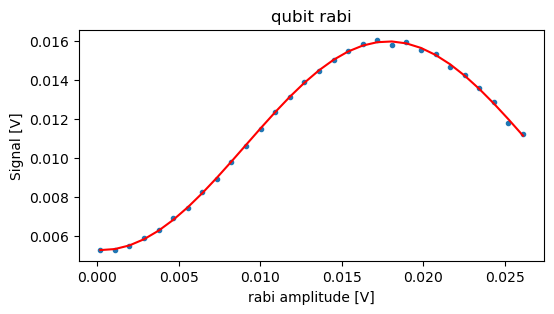

In [152]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [153]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.tolist()
machine = Analysis.set_machine(machine)

## T1

In [92]:
%matplotlib qt
tau_sweep_abs = np.arange(100,30E3+1,500)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 10E3, cd_time = 50E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 39.47s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 39.51s


Qubit T1 [us]: 4.517278851526467


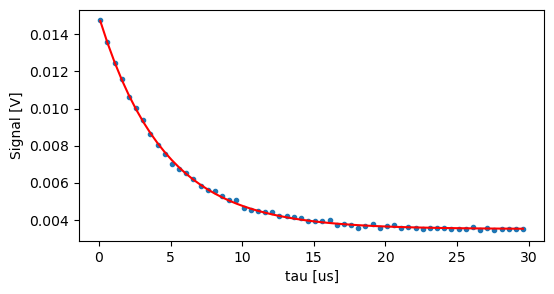

In [93]:
%matplotlib inline
q1_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q1_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

In [94]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 1500 + 0.1, 5)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_amp = Experiment.exp1D.Ramsey.ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, 
          n_avg = 5E3, detuning = 2E6, cd_time = 25E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 43.61s


Qubit T2* [ns]: 4969.002557369595
Detuning [MHz]: -0.2261973920784872
Exponent n: 0.6816606830638083


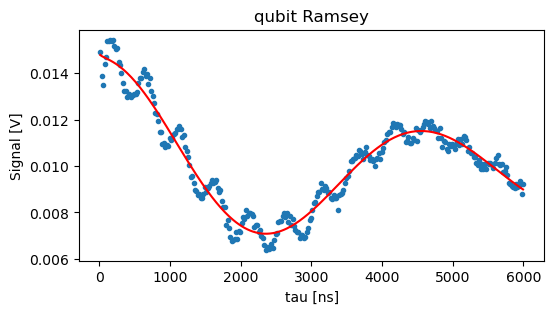

In [96]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_amp,plot_flag = True)
machine.qubits[qubit_index].T2 = int(q_T2star.tolist())
machine = Analysis.set_machine(machine)

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-180E6, -100E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[1] = 64
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 2.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs dc flux

In [76]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [97]:
machine = Analysis.get_machine()

In [98]:
# try the experiment
%matplotlib inline
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.48,0.48+1E-4,0.02)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 2E3, cd_time = 25E3, pi_amp_rel = 1.0, plot_flag = True)

KeyboardInterrupt: 

<Figure size 600x300 with 0 Axes>

In [78]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

sweet spot flux: -1.22579 V


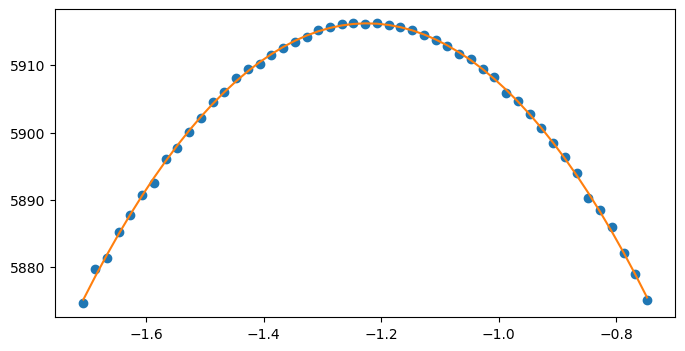

In [79]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [80]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, to find the initial fast flux tuning curve

2024-03-18 20:54:25,941 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-18 20:54:25,949 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.666 GHz, 250.000 MHz)
2024-03-18 20:54:31,886 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-03-18 20:55:09,055 - qm - INFO     - Performing health check.1% (n=4/7) --> elapsed time: 43.06s


INFO:qm.api.frontend_api:Performing health check


2024-03-18 20:55:09,063 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.521 GHz, 250.000 MHz)
2024-03-18 20:55:14,656 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-03-18 20:55:39,178 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-18 20:55:39,187 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.408 GHz, 250.000 MHz)
2024-03-18 20:55:44,755 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-03-18 20:56:09,139 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-18 20:56:09,150 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.262 GHz, 250.000 MHz)
2024-03-18 20:56:15,067 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=7/7) --> elapsed time: 133.68s
2024-03-18 20:56:39,675 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-18 20:56:39,683 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.083 GHz, 250.000 MHz)
2024-03-18 20:56:45,345 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


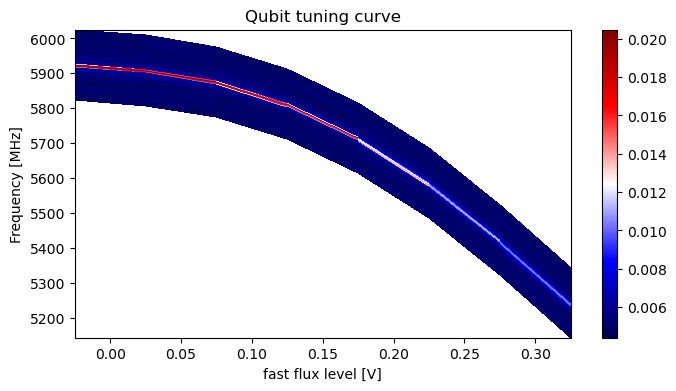

In [84]:
# try the experiment
%matplotlib inline
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.3+1E-4,0.05)
qubit_if_sweep = np.arange(-100E6, 100E6 + 1, 1E6)
if False: # first time running this, no AC_tuning_curve
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = 6.25, machine = machine, n_avg = 1E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)
else: # after the first run 
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, machine = machine, n_avg = 1E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)

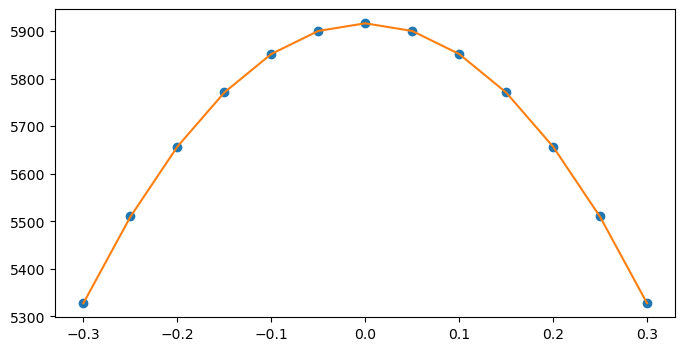

In [85]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [90]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4.3E9, -5E6)
#qubit_freq_sweep = np.arange(5.85E9,4.5E9,-50E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

2024-03-18 21:16:24,722 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-18 21:16:24,733 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.614 GHz, 200.000 MHz)
2024-03-18 21:16:30,274 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.78s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.93s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.80s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.95s
2024-03-18 21:23:51,503 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-18 21:23:51,517 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (5.414 GHz, 200.000 MHz)
2024-03-18 21:23:57,604 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.87s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 208.03s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.73s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.89s
2024-03-18 21:31:17,827 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-18 21:31:17,838 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (4.814 GHz, 200.000 MHz)
2024-03-18 21:31:23,646 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.82s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.98s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.78s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.94s
2024-03-18 21:38:45,034 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-18 21:38:45,048 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (4.614 GHz, 200.000 MHz)
2024-03-18 21:38:50,885 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.66s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.81s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.66s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 207.82s
2024-03-18 21:46:12,787 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-18 21:46:12,802 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (4.014 GHz, 200.000 MHz)
2024-03-18 21:46:18,503 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 15.55s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 15.71s
2024-03-18 21:46:56,192 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-03-18 21:46:56,203 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q3 for (LO, IF) = (3.814 GHz, 200.000 MHz)
2024-03-18 21:47:02,347 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


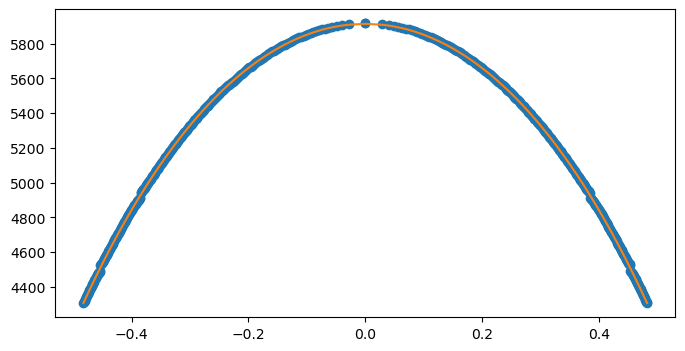

In [91]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

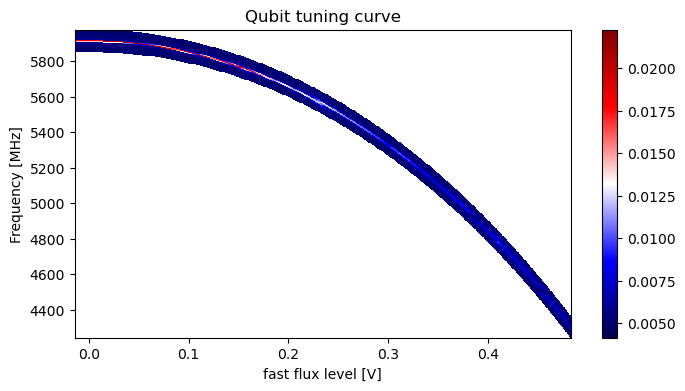

In [92]:
%matplotlib inline
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
plt.pcolormesh( ff_sweep_abs, qubit_freq_sweep.T / u.MHz,sig_amp_qubit.T, cmap="seismic")
plt.title("Qubit tuning curve")
plt.xlabel("fast flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

# TLS experiments

## TLS SWAP spectroscopy

In [141]:
# machine.qubits[qubit_index].f_01 = round(np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0).tolist()*1E6) + 0E6
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] +0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)

In [142]:
machine = Analysis.get_machine()
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True, machine = machine)

2024-02-27 17:02:02,818 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-27 17:02:02,832 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-27 17:02:10,117 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.966 GHz, -50.000 MHz)
2024-02-27 17:02:22,907 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


### coarse, no baking

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 640.83s


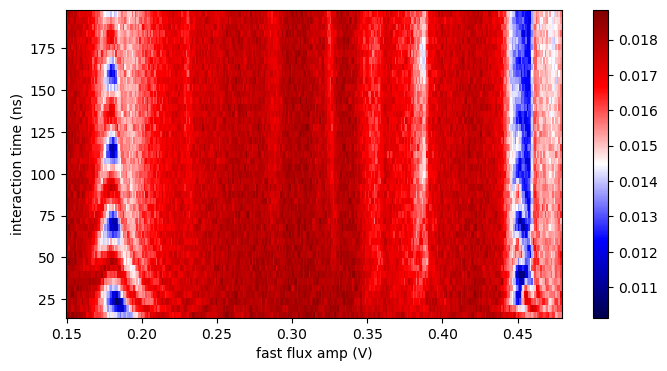

In [143]:
%matplotlib inline
tau_sweep_abs = np.arange(16,200,4)
ff_sweep_abs = np.arange(0.15,0.48,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 2E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

### fine, with baking

In [277]:
%matplotlib qt
tau_sweep_abs = np.arange(4,120,1)
ff_sweep_abs = np.arange(0.43,0.5,0.0005)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 4E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 2676.27s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 2676.43s
Execution stopped by user!


In [145]:
machine.flux_lines[flux_index].iswap.length[TLS_index] = 26
machine.flux_lines[flux_index].iswap.level[TLS_index] = 0.183
machine = Analysis.set_machine(machine)

In [278]:
machine.flux_lines[flux_index].iswap.length.append(27)
machine.flux_lines[flux_index].iswap.level.append(0.4489)
machine = Analysis.set_machine(machine)

### estiguess of the TLS freq., based on SWAP flux

In [279]:
machine = Analysis.get_machine()

In [148]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
machine.qubits[qubit_index].f_tls[1] =(np.floor(freq_tls[0]*1E6))
machine = Analysis.set_machine(machine)

IndexError: list assignment index out of range

In [280]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
for f_tmp in freq_tls:
    machine.qubits[qubit_index].f_tls.append(np.floor(f_tmp*1E6))
machine = Analysis.set_machine(machine)

## TLS T1

In [151]:
TLS_index = 0

In [288]:
%matplotlib qt
tau_sweep_abs = np.arange(200,100E3+1,5E3)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index = 1,
                   n_avg = 5E3, cd_time_qubit = 20E3, cd_time_TLS = 200E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Execution stopped by user!################################   ] 94.6% (n=4729/5000.0) --> elapsed time: 27.24s


Qubit T1 [us]: 3.8093406741569424


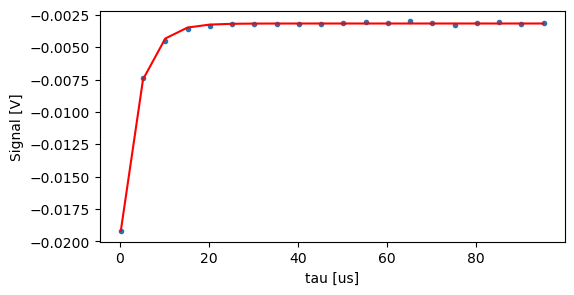

In [290]:
%matplotlib inline
tls_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

### TLS spectroscopy

In [158]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01

In [159]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
TLS_freq_est = np.round(TLS_freq_est[0] * 1E6)
if len(machine.qubits[qubit_index].f_tls) < TLS_index + 2: # need to increase size
    machine.qubits[qubit_index].f_tls.append(int(TLS_freq_est.tolist()) + 0E6)
    machine.qubits[qubit_index].lo.append(int(TLS_freq_est.tolist()) - 200E6)
else: # just update the value
    machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
    machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

In [160]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] + 0E6
machine = Analysis.set_machine(machine)

In [216]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-02-28 17:06:50,964 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-02-28 17:06:50,978 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r3 for (LO, IF) = (6.930 GHz, -50.000 MHz)
2024-02-28 17:06:58,304 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q3 for (LO, IF) = (5.560 GHz, 200.000 MHz)
2024-02-28 17:07:11,715 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [211]:
%matplotlib qt
TLS_freq_sweep = machine.qubits[qubit_index].f_tls[TLS_index+1] + np.arange(-10E6,27E6+1,0.5E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 1E3, cd_time_qubit = 20E3, cd_time_TLS = 1000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 76.40s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 76.50s


resonant frequency: 5759.598 MHz


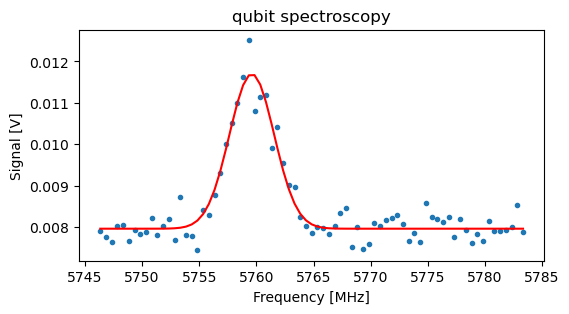

In [215]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
# update TLS freq
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
# save the parameters
machine = Analysis.set_machine(machine)

### TLS rabi

In [ ]:
machine.flux_lines[flux_index].iswap.level[TLS_index] = 0.183
machine = Analysis.set_machine(machine)

In [235]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 100 + 0.1, 1)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  n_avg = 1E3, cd_time_qubit = 20E3, cd_time_TLS = 1000E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 98.74s


T2rabi: 2070.9 ns
rabi_pi_pulse: 100.3 ns
half period: 97.75 ns


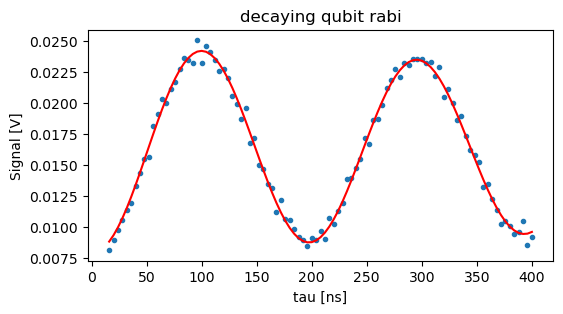

In [237]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,method = "decaying_time_rabi", plot_flag = True)

In [217]:
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_length_tls.append(100)
else: # just update the value
    machine.qubits[qubit_index].pi_length_tls[TLS_index] = 100
    
machine = Analysis.set_machine(machine)

### Power Rabi

In [238]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 1.5, 0.01) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, TLS_index = TLS_index,  
                                          n_avg = 1E3, cd_time_qubit = 20E3, cd_time_TLS = 1500E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 182.34s


rabi_pi_pulse_amp: 0.27104 V
half period: 0.1526902 V


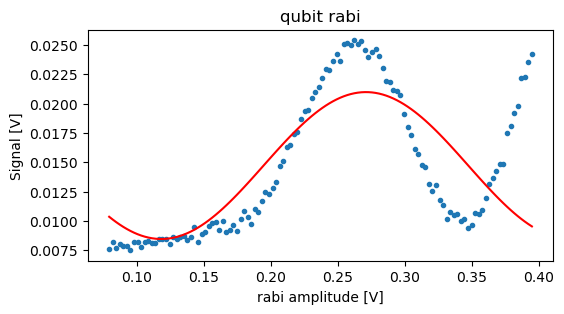

In [242]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [234]:
pi_pulse_amp = 0.265
if len(machine.qubits[qubit_index].pi_length_tls) < TLS_index + 1: # need to increase size
    machine.qubits[qubit_index].pi_amp_tls.append(pi_pulse_amp)
else: # just update the value
    machine.qubits[qubit_index].pi_amp_tls[TLS_index] = pi_pulse_amp
machine = Analysis.set_machine(machine)